In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import LinearOperator, gmres
from lazy_imports import loadmat, savemat
from lazy_imports import sitk
import scipy.io as sio
from scipy.spatial.distance import directed_hausdorff
from IPython.core.display import display, HTML
plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
%matplotlib notebook
display(HTML("<style>.container { width:55% !important; }</style>"))

In [3]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file

In [4]:
from data.io import readRaw, ReadTensors, ReadScalars, WriteTensorNPArray
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP
import data.gen

In [5]:
from util import diff
from util.diffeo import coord_register
from util import tensors
from util import maskops as mo
from util.riemann import riem_vec_norm

In [6]:
from util.tensors import scale_by_alpha

In [7]:
import algo.metricModSolver2d as mms
import algo.geodesic as geo
import algo.euler as euler
import algo.dijkstra as dijkstra

## I/O convention
Due to the certain reason of Kris' simulated data generation, please follow the i/o convention below which is symmetric, to make sure the files are read and written correctly. Following example is for 2D situation, 3D case is analogous.
### Read
Shape of input_tensor.nhdr is [w, h, 3], and Shape of input_mask.nhdr is [w, h]
```
input_tensor = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(2,1,0))
input_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(1,0))
```
input_tensor.shape is [3, h, w], and input_mask.shape is [h, w]
### Write
output_tensor.shape is [3, h, w], and output_mask.shape is [h, w]
```
output_tensor = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
output_mask = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
```
Shape of output_tensor.nhdr is [w, h, 3], and Shape of output_mask.nhdr is [w, h]

## Caveat
When using  `coord_register(geoy, geox, diffeo)`, remember to put `geoy` first, then goes the `geox`!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## 2D

In [8]:
path = '/home/sci/hdai/Projects/Atlas2D/Output/Cubic1246Atlas'

In [9]:
def mean_of_min_dist(curve1, curve2):
#     length = min(curve1.shape[0], curve2.shape[0])
# #     dist_array = np.sqrt((curve1[:length,0]-curve2[:length,0])**2+(curve1[:length,1]-curve2[:length,1])**2)
#     dist_array = np.sqrt((curve1[-length:,0]-curve2[-length:,0])**2+(curve1[-length:,1]-curve2[-length:,1])**2)
    min_list = []
    for i in range(curve1.shape[0]):
        min_list.append(np.min(np.sqrt((curve2[:,0]-curve1[i,0])**2+(curve2[:,1]-curve1[i,1])**2)))
#     return np.min(dist_array)
    return np.mean(np.array(min_list))

In [114]:
# geox_list, geoy_list = [],[]

# ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/atlas_40_tens.nhdr')),(2,1,0))
# filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/atlas_0_mask.nhdr')),(1,0))
# mat_4_path = np.zeros((100,100,2,2))
# mat_4_path[:,:,0,0] = ten_4_path[0]
# mat_4_path[:,:,0,1] = ten_4_path[1]
# mat_4_path[:,:,1,0] = ten_4_path[1]
# mat_4_path[:,:,1,1] = ten_4_path[2]
# invmat_4_path = np.linalg.inv(mat_4_path)
# invten_4_path = np.zeros((3,100,100))
# invten_4_path[0] = invmat_4_path[:,:,0,0]
# invten_4_path[1] = invmat_4_path[:,:,0,1]
# invten_4_path[2] = invmat_4_path[:,:,1,1]

# start_coords = [[13, 14]]
# init_velocities = [None]
# t1_file = None
# tens_scale = 1e-1
# geo_delta_t = 0.1
# geo_iters = 60000
# geox, geoy = geo.geodesicpath(ten_4_path, filt_mask,\
#                                   start_coords[0], init_velocities[0], \
#                                   geo_delta_t, iter_num=geo_iters, both_directions=False)
    
# geox_list.append(geox)
# geoy_list.append(geoy)
# # tens_fig = vis_tensors(invten_4_path*np.stack((filt_mask,filt_mask,filt_mask),0), f'cubic1', False, scale=5e2)
# tens_fig = vis_tensors(ten_4_path*np.stack((filt_mask,filt_mask,filt_mask),0), f'cubic1', False, scale=5e-4)
# vis_path(geox, geoy, tens_fig, "Geodesic Original Tensors", 'tab:blue', 80, 1, False)

## Geodesic on cubic5

In [10]:
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic5_scaled_tensors.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic5_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
gt_geox, gt_geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)

Finding geodesic path from [13, 14] with initial velocity [0.27513762 0.96140485]


## Geodesic on atlas

In [11]:
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Output/Cubic1246Atlas/atlas_100_tens.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic5_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
atlas_geox, atlas_geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)

Finding geodesic path from [13, 14] with initial velocity [0.27003975 0.96284917]


## Hausdorff between registered geodesic on cubic1 and geodesic on atlas/cubic5

In [29]:
cubic1_dist = []
cubic_num = 1
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_scaled_tensors.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
geox, geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)
    
for i in range(0,101,5):
# if True:
#     i=80
    diffeo = sio.loadmat(f'Output/Cubic1246Atlas/cubic{cubic_num}_{i}_phi.mat')['diffeo']
    new_geoy, new_geox = coord_register(geoy, geox, diffeo)
#     tens_fig = vis_tensors(ten_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
# #     vis_path(geox, geoy, tens_fig, "cubic", 'tab:blue', 40, 1, False)
#     vis_path(new_geox[800:802], new_geoy[800:802], tens_fig, "registered", 'tab:red', 40, 1, False)
# #     vis_path(gt_geox, gt_geoy, tens_fig, "groundtruth", 'tab:green', 40, 1, False)
#     vis_path(atlas_geox[900:902], atlas_geoy[900:902], tens_fig, "atlas", 'tab:orange', 40, 1, False)
    
    geo_subject_registered = np.concatenate((np.expand_dims(np.array(new_geox),axis=1),np.expand_dims(np.array(new_geoy),axis=1)),axis=1)
    geo_gt = np.concatenate((np.expand_dims(np.array(gt_geox),axis=1),np.expand_dims(np.array(gt_geoy),axis=1)),axis=1)
    geo_atlas = np.concatenate((np.expand_dims(np.array(atlas_geox),axis=1),np.expand_dims(np.array(atlas_geoy),axis=1)),axis=1)
#     dist_hausdorff = directed_hausdorff(geo_subject_registered, geo_atlas)[0]
#     cubic1_dist.append(dist_hausdorff)
#     print(dist_hausdorff)
    dist_mean = mean_of_min_dist(geo_subject_registered, geo_atlas)
    cubic1_dist.append(dist_mean)
    print(dist_mean)

Finding geodesic path from [13, 14] with initial velocity [0.32249473 0.94657126]
2.8967245288010317
1.7777036370661263
1.1553437793410324
0.863958077400405
0.7199549575086014
0.639773585335763
0.5984786984413406
0.584708274486787
0.5781365794734926
0.5735681624103193
0.569603569580335
0.5659259676568427
0.5622095428229266
0.558676386369756
0.5553129476230967
0.5520904257515897
0.5489715256846104
0.5459597122891053
0.5431552506638709
0.5405066526178168
0.5379396057386839


In [30]:
tens_list = []
tens_list.append(ten_4_path)

## Hausdorff between registered geodesic on cubic2 and geodesic on atlas/cubic5

In [31]:
cubic2_dist = []
cubic_num = 2
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_scaled_tensors.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
geox, geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)
    
for i in range(0,101,5):
    diffeo = sio.loadmat(f'Output/Cubic1246Atlas/cubic{cubic_num}_{i}_phi.mat')['diffeo']
    new_geoy, new_geox = coord_register(geoy, geox, diffeo)
#     tens_fig = vis_tensors(ten_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
#     vis_path(geox, geoy, tens_fig, "cubic", 'tab:blue', 40, 1, False)
#     vis_path(new_geox, new_geoy, tens_fig, "registered", 'tab:red', 40, 1, False)
#     vis_path(gt_geox, gt_geoy, tens_fig, "groundtruth", 'tab:green', 40, 1, False)
#     vis_path(atlas_geox, atlas_geoy, tens_fig, "atlas", 'tab:orange', 40, 1, False)
    
    geo_subject_registered = np.concatenate((np.expand_dims(np.array(new_geox),axis=1),np.expand_dims(np.array(new_geoy),axis=1)),axis=1)
    geo_gt = np.concatenate((np.expand_dims(np.array(gt_geox),axis=1),np.expand_dims(np.array(gt_geoy),axis=1)),axis=1)
    geo_atlas = np.concatenate((np.expand_dims(np.array(atlas_geox),axis=1),np.expand_dims(np.array(atlas_geoy),axis=1)),axis=1)
#     dist_hausdorff = directed_hausdorff(geo_subject_registered, geo_atlas)[0]
#     cubic2_dist.append(dist_hausdorff)
#     print(dist_hausdorff)
    dist_mean = mean_of_min_dist(geo_subject_registered, geo_atlas)
    cubic2_dist.append(dist_mean)
    print(dist_mean)

Finding geodesic path from [13, 14] with initial velocity [0.22961718 0.97328102]
3.318115831685355
2.2872426630750002
1.7149908129612992
1.3787415339791478
1.1736626487002706
1.0428475084189812
0.955986766086406
0.8960495230394776
0.8531501258193881
0.8212855031497243
0.7968339506677357
0.777480035566518
0.7616493557955851
0.74837896499253
0.7370910045449421
0.7272657803335846
0.7185401084728518
0.7107492315769366
0.7037827946212898
0.6974483151427155
0.6916302661028711


In [32]:
tens_list.append(ten_4_path)

## Hausdorff between registered geodesic on cubic4 and geodesic on atlas/cubic5

In [33]:
cubic4_dist = []
cubic_num = 4
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_scaled_tensors.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
geox, geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)
    
for i in range(0,101,5):
    diffeo = sio.loadmat(f'Output/Cubic1246Atlas/cubic{cubic_num}_{i}_phi.mat')['diffeo']
    new_geoy, new_geox = coord_register(geoy, geox, diffeo)
#     tens_fig = vis_tensors(ten_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
#     vis_path(geox, geoy, tens_fig, "cubic", 'tab:blue', 40, 1, False)
#     vis_path(new_geox, new_geoy, tens_fig, "registered", 'tab:red', 40, 1, False)
#     vis_path(gt_geox, gt_geoy, tens_fig, "groundtruth", 'tab:green', 40, 1, False)
#     vis_path(atlas_geox, atlas_geoy, tens_fig, "atlas", 'tab:orange', 40, 1, False)
    
    geo_subject_registered = np.concatenate((np.expand_dims(np.array(new_geox),axis=1),np.expand_dims(np.array(new_geoy),axis=1)),axis=1)
    geo_gt = np.concatenate((np.expand_dims(np.array(gt_geox),axis=1),np.expand_dims(np.array(gt_geoy),axis=1)),axis=1)
    geo_atlas = np.concatenate((np.expand_dims(np.array(atlas_geox),axis=1),np.expand_dims(np.array(atlas_geoy),axis=1)),axis=1)
#     dist_hausdorff = directed_hausdorff(geo_subject_registered, geo_atlas)[0]
#     cubic4_dist.append(dist_hausdorff)
#     print(dist_hausdorff)

    dist_mean = mean_of_min_dist(geo_subject_registered, geo_atlas)
    cubic4_dist.append(dist_mean)
    print(dist_mean)

Finding geodesic path from [13, 14] with initial velocity [0.26587849 0.96400655]
0.8488663452409569
0.6141317328793943
0.49648439102504965
0.4535538282311163
0.4412415794507539
0.43487949466331305
0.4314390894990118
0.42975491376534
0.4288771888694543
0.4283338885535385
0.4279740245902054
0.42773746271405416
0.4275914977503837
0.4275142992701475
0.42749213659966423
0.4275087391770165
0.4275682857468648
0.4276525977914939
0.42776446004647484
0.4278927951088438
0.42802813546311264


In [34]:
tens_list.append(ten_4_path)

## Hausdorff between registered geodesic on cubic6 and geodesic on atlas/cubic5

In [35]:
cubic6_dist = []
cubic_num = 6
ten_4_path = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_scaled_tensors.nhdr')),(2,1,0))
filt_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{cubic_num}_filt_mask.nhdr')),(1,0))

start_coords = [[13, 14]]
init_velocities = [None]
t1_file = None
tens_scale = 1e-1
geo_delta_t = 0.1
geo_iters = 60000
geox, geoy = geo.geodesicpath(ten_4_path, filt_mask,\
                                      start_coords[0], init_velocities[0], \
                                      geo_delta_t, iter_num=geo_iters, both_directions=False)
    
for i in range(0,101,5):
    diffeo = sio.loadmat(f'Output/Cubic1246Atlas/cubic{cubic_num}_{i}_phi.mat')['diffeo']
    new_geoy, new_geox = coord_register(geoy, geox, diffeo)
#     tens_fig = vis_tensors(ten_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
#     vis_path(geox, geoy, tens_fig, "cubic", 'tab:blue', 40, 1, False)
#     vis_path(new_geox, new_geoy, tens_fig, "registered", 'tab:red', 40, 1, False)
#     vis_path(gt_geox, gt_geoy, tens_fig, "groundtruth", 'tab:green', 40, 1, False)
#     vis_path(atlas_geox, atlas_geoy, tens_fig, "atlas", 'tab:orange', 40, 1, False)
    
    geo_subject_registered = np.concatenate((np.expand_dims(np.array(new_geox),axis=1),np.expand_dims(np.array(new_geoy),axis=1)),axis=1)
    geo_gt = np.concatenate((np.expand_dims(np.array(gt_geox),axis=1),np.expand_dims(np.array(gt_geoy),axis=1)),axis=1)
    geo_atlas = np.concatenate((np.expand_dims(np.array(atlas_geox),axis=1),np.expand_dims(np.array(atlas_geoy),axis=1)),axis=1)
#     dist_hausdorff = directed_hausdorff(geo_subject_registered, geo_atlas)[0]
#     cubic6_dist.append(dist_hausdorff)
#     print(dist_hausdorff)

    dist_mean = mean_of_min_dist(geo_subject_registered, geo_atlas)
    cubic6_dist.append(dist_mean)
    print(dist_mean)

Finding geodesic path from [13, 14] with initial velocity [0.28446983 0.95868499]
0.7743015689516707
0.6393359800648324
0.5875908707262048
0.5602971884613235
0.5447120923374803
0.5338206414447664
0.5261711659042958
0.5212320452982303
0.518104327724401
0.5158785615170596
0.5145525003757587
0.5139053883834483
0.5137064676442806
0.5137323258944978
0.5138661509831304
0.5140264970591261
0.5141902756769796
0.5143172862806276
0.514509080790415
0.5147533321274168
0.5150242583873238


In [36]:
tens_list.append(ten_4_path)

In [16]:
# plt.figure(figsize=(8,4))
# plt.plot(list(range(0,101,5)),cubic1_dist, label='cubic 1')
# plt.plot(list(range(0,101,5)),cubic2_dist, label='cubic 2')
# plt.plot(list(range(0,101,5)),cubic4_dist, label='cubic 4')
# plt.plot(list(range(0,101,5)),cubic6_dist, label='cubic 6')
# plt.legend(loc='upper right', ncol=1)
# plt.title(f'Hausdorff distance between the geodesics on subjects and atlas')
# plt.xlabel('Iterations')
# plt.ylabel('Hausdorff distance')

In [18]:
interp_colors = ['#777777','#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

# use first 4 colors in interp_colors for metrics 1-4

# matches defaults
XSMALL_SIZE = 12
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
# bigger for papers
XSMALL_SIZE = 12
SMALL_SIZE = 17
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


<IPython.core.display.Javascript object>


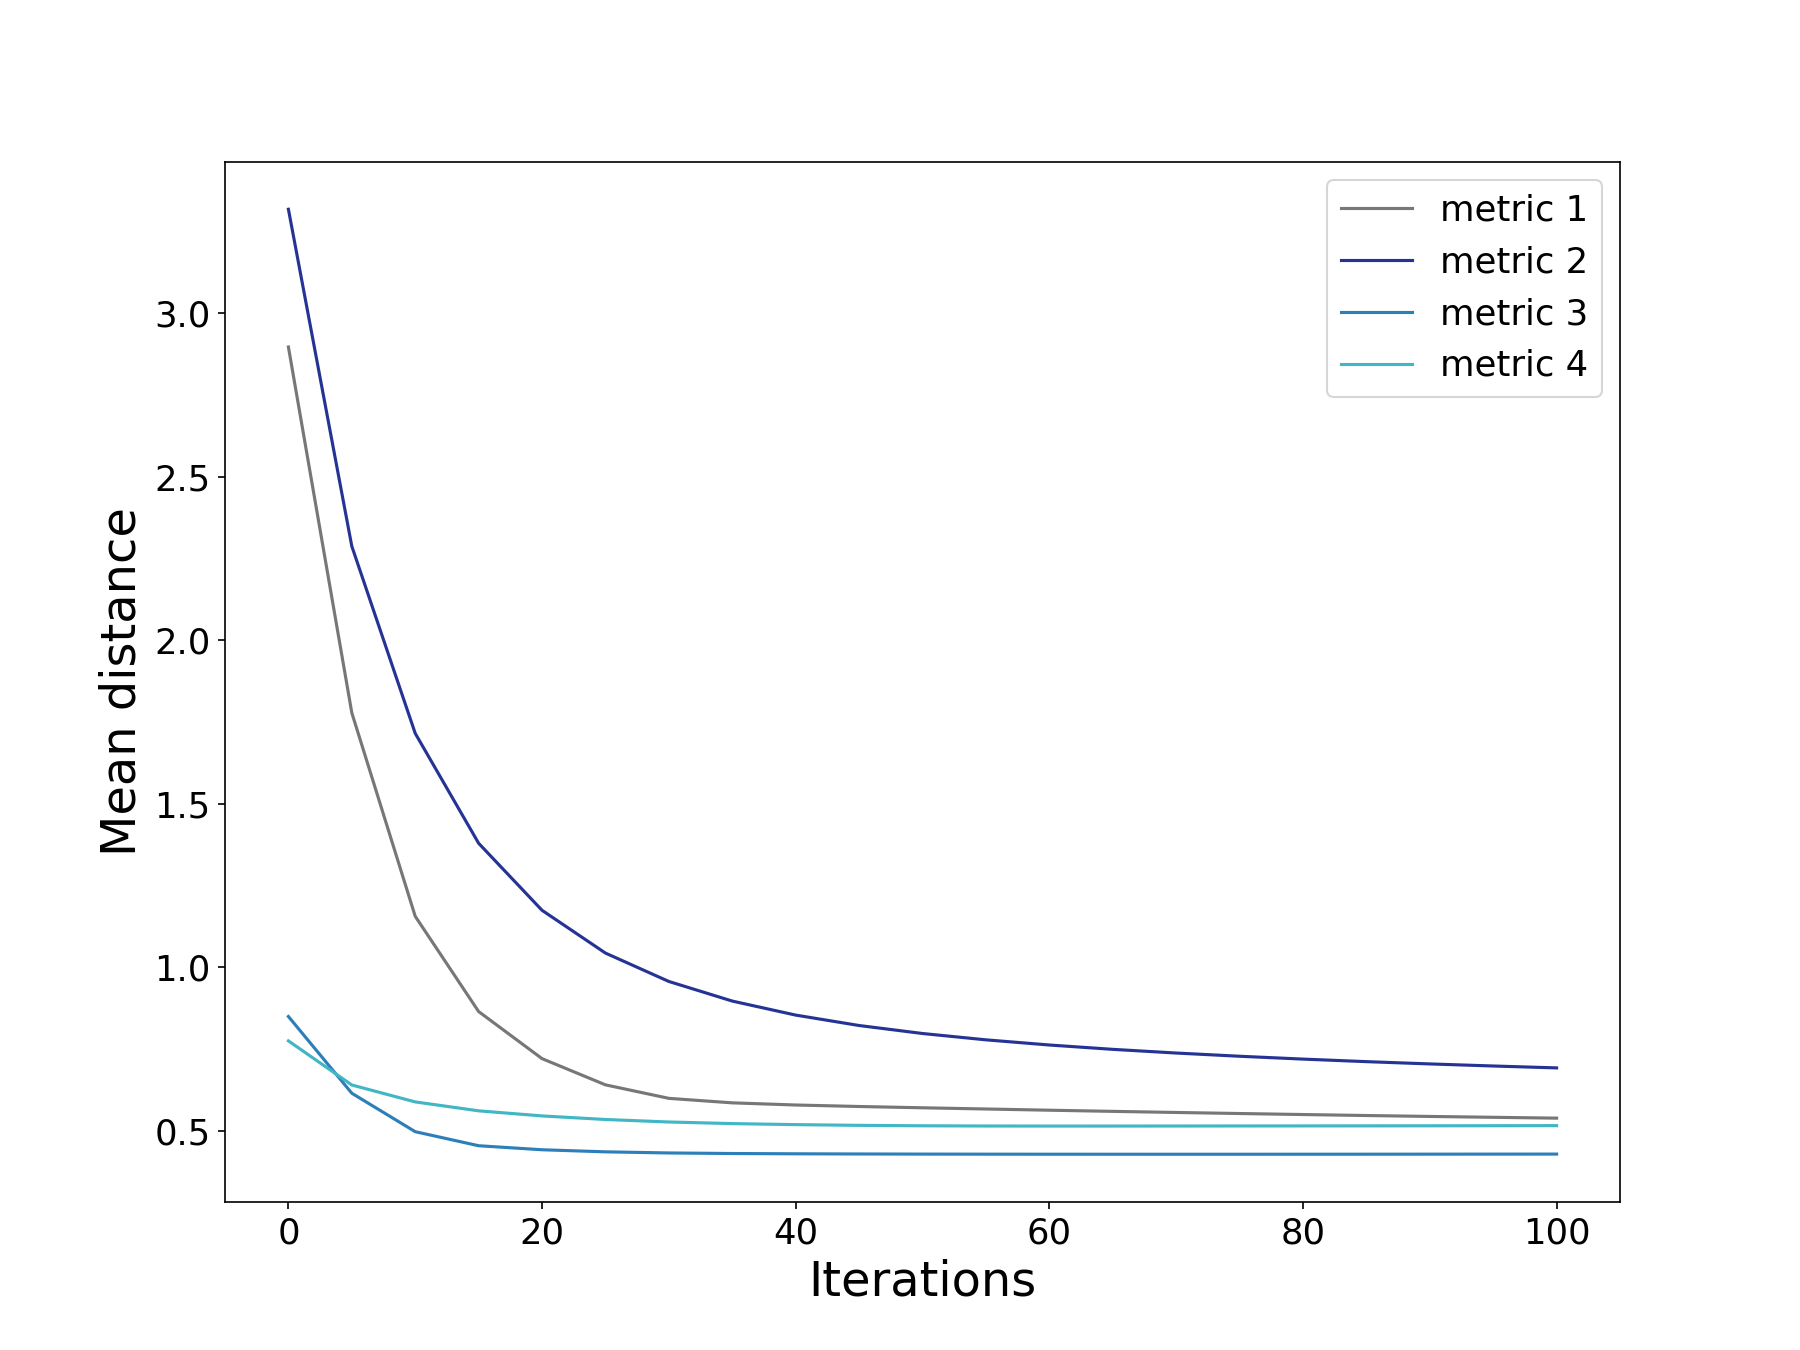

In [28]:
plt.figure(figsize=(12,9))
plt.plot(list(range(0,101,5)),cubic1_dist, label='metric 1', color=interp_colors[0])
plt.plot(list(range(0,101,5)),cubic2_dist, label='metric 2', color=interp_colors[1])
plt.plot(list(range(0,101,5)),cubic4_dist, label='metric 3', color=interp_colors[2])
plt.plot(list(range(0,101,5)),cubic6_dist, label='metric 4', color=interp_colors[3])
plt.legend(loc='upper right', ncol=1)
# plt.title(f'Mean distance between the geodesics on subjects and atlas')
plt.xlabel('Iterations')
plt.ylabel('Mean distance')
plt.savefig('dist_plot.pdf')

In [54]:
import random
import torch
random.shuffle(tens_list)

In [55]:
np.sum(tens_list[0])

20497.03420451364

In [68]:
a=list(range(6))
b=a.copy()
random.shuffle(a)
c=dict(zip(b,a))

In [69]:
c

{0: 2, 1: 5, 2: 4, 3: 1, 4: 3, 5: 0}